In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from math import factorial
%matplotlib inline

# Estimation of Physical Parameters of Jump-Diffusion (Pricing) Model via Maximum Likelihood (ML) Estimation
---

## Contents
---

1. [DataFrame Setup and Data Summary](#sec1)
2. [Understanding Model Dynamics](#sec2)
3. [Maximum Likelihood Estimation (MLE)](#sec3)
4. [Standard Errors and Hypothesis Testing](#sec4)
5. [Final Results - Estimated Parameters, Standard Errors, P-values and Limitations](#sec5)

<a id='sec1'></a>
## 1. `DataFrame Setup and Data Summary`
---
In this section we will read our time-series of daily closing prices of a stock from a csv file as a **`pandas` DataFrame** and set it up for our analysis and parameter estimation task. We will also see few summary statistics and plots to get a sense of data.

We do the following $-$ 
- Read the csv file into a DataFrame `stock_df`
- Clean the DataFrame
- Get the columns
    - `Spot`, $S_t \Rightarrow$ Spot price (*at close*)
    - `Log Return`, $X_t = \ln \left( S_t / S_0 \right) \Rightarrow$ Logarithmic returns
    - `Daily Log Return`, $X_{\Delta t} = X_{t_{i}} - X_{t_{i-1}} \Rightarrow$ Daily logarithmic returns
- See summary statistics and plots

##### Read Data and DataFrame `stock_df` Setup

In [2]:
stock_df = pd.read_csv('price_history.csv', index_col = 0, header = None, parse_dates = True)    # read csv file
stock_df.index.rename('Date', inplace = True)                                                    # index rename
stock_df.rename(columns = {1: 'Spot'}, inplace = True)                                           # price column rename

stock_df['Log Return'] = np.log(stock_df['Spot'] / stock_df['Spot'][0])                          # add column 'Log Return'
stock_df['Daily Log Return'] = stock_df['Log Return'].diff()                                     # add column 'Daily Log Return'

print('======== data types ========')
print(stock_df.dtypes)                                                                           # check data types
print(f'Index : {stock_df.index.dtype}')
print('============================')

stock_df

======== data types ========
Spot                float64
Log Return          float64
Daily Log Return    float64
dtype: object
Index : datetime64[ns]


,Spot,Log Return,Daily Log Return
Date,,,
2007-01-02,55.615475,0.000000,NaN
2007-01-03,55.963382,0.006236,0.006236
2007-01-04,54.710916,-0.016398,-0.022634
2007-01-05,56.062784,0.008011,0.024409
2007-01-08,55.655236,0.000715,-0.007296
...,...,...,...
2018-04-18,174.360000,1.142661,-0.002177
2018-04-19,173.280000,1.136447,-0.006213
2018-04-20,171.100000,1.123787,-0.012661


##### Summary Statistics

In [3]:
stock_df.describe()                

,Spot,Log Return,Daily Log Return
count,2871.000000,2871.000000,2870.000000
mean,125.186128,0.726464,0.000389
std,47.276861,0.437438,0.025324
min,29.124815,-0.646871,-0.220877
25%,91.325679,0.495970,-0.011173
50%,125.050000,0.810252,0.000345
75%,162.275000,1.070831,0.012665
max,255.200000,1.523586,0.179723


##### Spot Price Plot

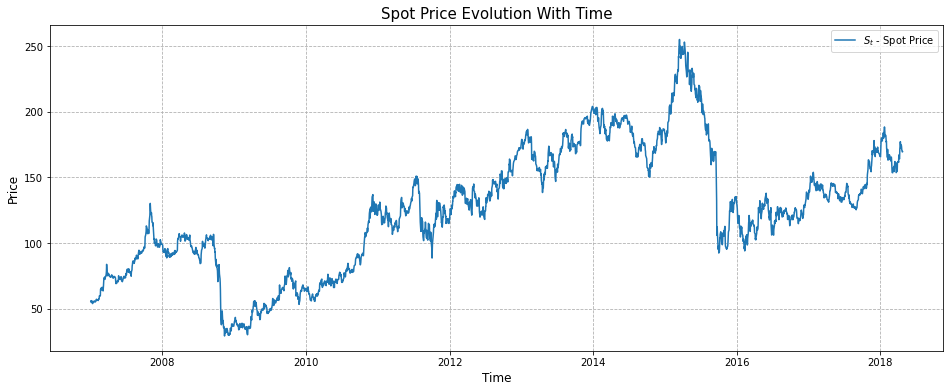

In [4]:
# spot price evolution plot
plt.figure(figsize = (16, 6))                                
plt.plot(stock_df['Spot'], label = f'$S_t$ - Spot Price')       
plt.xlabel('Time', size = 12)
plt.ylabel('Price', size = 12)
plt.title('Spot Price Evolution With Time', size = 15)
plt.grid(True, linestyle = '--')
plt.legend();

##### Normal pdf and Poisson pmf (will be useful later as well)

In [5]:
def normal_pdf(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / (sigma))**2) / (sigma * np.sqrt(2 * np.pi))

def poisson_pmf(n, avg):
    return np.exp(-avg) * (avg ** n) / factorial(n)

##### Daily Logarithmic Returns Plot

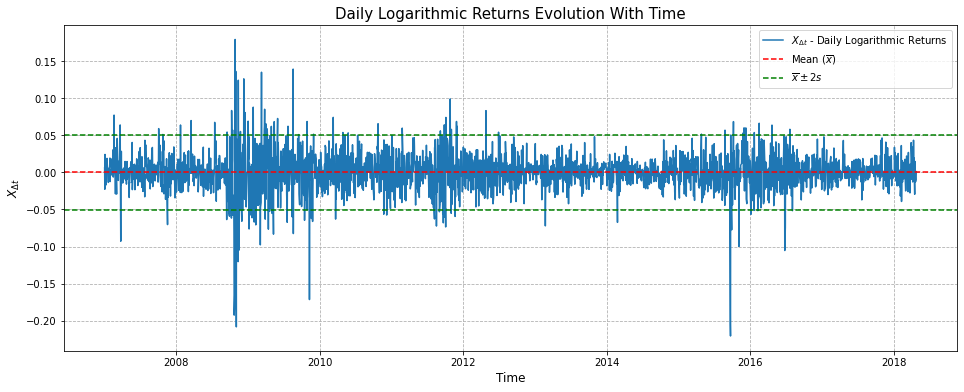

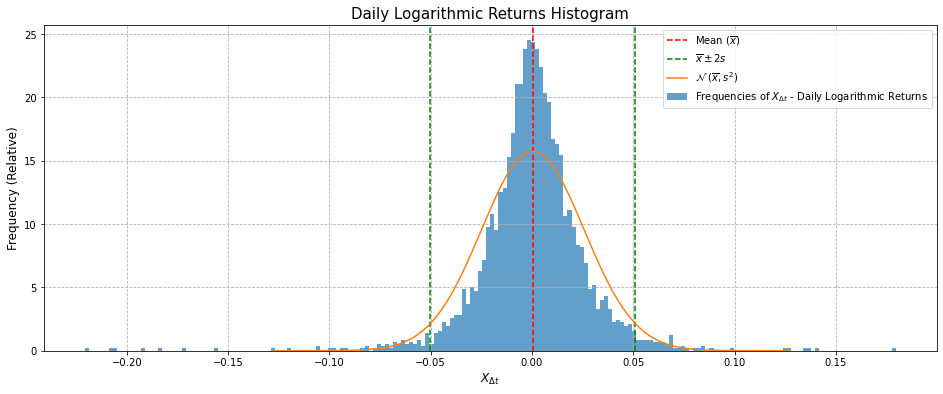

In [6]:
# sample statistics
mean = stock_df['Daily Log Return'].mean()                                                     
stddev = stock_df['Daily Log Return'].std()

# z-score bound -> to define 'extreme' moves, returns outside 2 std dev of sample mean
z_bound = 2

# daily logarithmic returns plot
plt.figure(figsize = (16, 6))                                
plt.plot(stock_df['Daily Log Return'], label = '$X_{\Delta t}$ - Daily Logarithmic Returns')       
plt.xlabel('Time', size = 12)
plt.ylabel('$X_{\Delta t}$', size = 12)
plt.title('Daily Logarithmic Returns Evolution With Time', size = 15)
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean ($\overline{x}$)')
plt.axhline(mean + z_bound * stddev, color = 'g', linestyle = '--', label = '$\overline{x}' + f' \pm {z_bound}s$')    # bounds
plt.axhline(mean - z_bound * stddev, color = 'g', linestyle = '--')
plt.grid(True, linestyle = '--')
plt.legend()

# histogram
plt.figure(figsize = (16, 6))                                
plt.hist(stock_df['Daily Log Return'], density = True, bins = 200, alpha = 0.7, label = 'Frequencies of $X_{\Delta t}$ - Daily Logarithmic Returns')
plt.xlabel('$X_{\Delta t}$', size = 12)
plt.ylabel('Frequency (Relative)', size = 12)
plt.title('Daily Logarithmic Returns Histogram', size = 15)
plt.axvline(mean, color = 'r', linestyle = '--', label = 'Mean ($\overline{x}$)')             
plt.axvline(mean + z_bound * stddev, color = 'g', linestyle = '--', label = '$\overline{x}' + f' \pm {z_bound}s$')    # bounds
plt.axvline(mean - z_bound * stddev, color = 'g', linestyle = '--')
x = np.linspace(mean - 5 * stddev, mean + 5 * stddev, 1000)                                       
plt.plot(x, normal_pdf(x, mean, stddev), label = '$\mathcal{N}\ (\overline{x}, s^{2})$')                              # normal curve
plt.grid(True, linestyle = '--')
plt.legend();

From the Daily Logarithmic Returns plot, it can be seen that the stock has made big moves (**jumps**) quite a few times.

Let's check how many times did the returns exceed $\overline{x} \pm 2s$ bound (*$s$ is sample standard deviation; ddof = 1*). Also, we will compute the average annual rate of exceeding the bounds (proxy for **intensity $\lambda$**).

We assume $252$ trading days in a year.

##### Bound ( $\overline{x} \pm 2s$ ) Exceed Count and Intensity Proxy

In [7]:
# bound exceed count
mask = (stock_df['Daily Log Return'] < (mean - z_bound * stddev)) | \
       (stock_df['Daily Log Return'] > (mean + z_bound * stddev))
bound_exceed_count = len(stock_df[mask])                               # boolean indexing
print('==== bound exceed count & intensity proxy ====')
print(f'Number of times bound exceeded: {bound_exceed_count}')        

# average bound exceed per year
trading_days = 252                                                     # per year
number_of_years = len(stock_df['Daily Log Return']) / trading_days          
bound_exceed_avg_rate = bound_exceed_count / number_of_years
print(f'Avg. annual rate (proxy for intensity): {bound_exceed_avg_rate:.2f}')
print('==============================================')

==== bound exceed count & intensity proxy ====
Number of times bound exceeded: 126
Avg. annual rate (proxy for intensity): 11.06


<a id='sec2'></a>
## 2. `Understanding Model Dynamics`
---

### Merton Jump-Diffusion Model

We consider the continuous-time price process $S_t$ of a limited liability spot asset. The corresponding logarithmic return process is defined as $X_t = \ln \left( S_t / S_0 \right)$. Under the Merton (1976) jump-diffusion model, the physical dynamics of $X_t$ are given by:

$$
X_t = \gamma t + \sigma W_t + \sum_{i=1}^{N_t} Y_i
$$

where,
- $\gamma \in \mathbb{R}$ is drift term
- $\sigma \in \mathbb{R}_+$ is diffusion coefficient (**annualized volatility**)
- $W_t$ is one-dimensional Brownian motion $\sim \mathcal{N}(0, t)$
- $N_t \sim POI(\lambda t)$ is a Compound Poisson random variable counting the jumps of $X_t$ in $[0,t]$; $\lambda \in \mathbb{R}_+$ is average rate of jumps per year (i.e. **intensity**)
- $\left\{ Y_i \right\}_{i \in \mathbb{N}}$ is a sequence of $i.i.d.$ normal random variables with distribution $\mathcal{N} \left( \alpha, \beta^2 \right)$ that denote the sizes of the jumps
    - $\alpha \in \mathbb{R}$ is mean of jump size
    - $\beta \in \mathbb{R}_+$ is standard deviation of jump size
    
Therefore, we have a total of 5 parameters which we denote by $\theta = \{ \gamma, \sigma, \lambda, \alpha, \beta \}$.

### Probability Density Function (pdf) Explanation

**Conditional** on number of jumps, $X_t$ follows normal distribution because $X_t$ is made up of 3 parts $-$
- $\gamma t$, which is a deterministic part
- $W_t$, a brownian motion that follows $\sim \mathcal{N}(0, t)$
- $n$ (*conditioned on* $N_t = n$) $i.i.d.$ jumps $Y_i$ $\sim \mathcal{N}(\alpha, \beta^2)$

The number of jumps ($n$), jump sizes ($Y_i$) and brownian motion ($W_t$) $-$ all 3 are **independent** of each other. Therefore, after applying some basic rules of **expectation** $\mathbb{E} \left[X \right]$ and **variance** $\mathbb{V}ar \left[X \right]$ computation, namely $-$
- *sum of independent normal variables is a normal variable*
- *constant shifts the mean but does not impact variance*
- *i.i.d. rules for mean and variance*

we get (*conditional*) pdf of $X_t$ as 
$$
f_{X_t}\left(x; \theta | N_t = n\right) = \Phi \left(x; \gamma t + n\alpha, \sigma^2 t + n\beta^2\right)
$$

Finally, since the number of jumps ($n$) can range from $0$ to $\infty$ (i.e. $n \in \mathbb{N}$), the final **pdf** is expressed as probability weighted average i.e. **conditional expectation** where the weights are pmf of $POI \left(\lambda t \right)$

$$
f_{X_t} \left(x; \theta \right) = \sum_{n=0}^{\infty} \Phi \left(x; \gamma t + n\alpha, \sigma^2 t + n\beta^2\right) \Psi \left(n \right)
$$

where,

$$
\Psi \left(n \right) = \frac{{(\lambda t )^n }}{{n!}}e^{ - \lambda t}
$$

is the probability mass function (**pmf**) of $N_t$ with **intensity** $\lambda$ and

$$
\Phi \left(x; \alpha, \beta^2 \right) = \frac{1}{\beta\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\alpha}{\beta}\right)^{\!2}\,\right)
$$
is the probability density function of a normal distribution with mean $\alpha$ and variance $\beta^2$.

### Provided Tip (*model the increments*)

> *To simplify the analysis, you may assume that the samples are equally spaced with $\Delta t = 1\ /\ 252$ years on a time grid*
>
>$$\Pi = \left\{ t_0 = 0,t_1 = \Delta t,t_2 = 2\Delta t,...\right\}$$
>
> *When estimating the model based on equally spaced data sets, it is easier not to estimate the process $X_t$ directly but instead to use that its increments are i.i.d. with distribution i.e.*
>$$X_{t_{i}} - X_{t_{i-1}} \sim X_{\Delta t}$$

Again, after applying rules of probability theory and properties of underlying distributions, namely $-$
- *$W_{t_{i}} - W_{t_{i-1}} = W_{\Delta t} \sim \mathcal{N}(0, \Delta t)$*
- *$N_{t_{i}} - N_{t_{i-1}} = N_{\Delta t} \sim POI(\lambda \Delta t)$*
- *$\gamma t_{i} - \gamma t_{i-1} = \gamma \Delta t$*

we can say that the physical dynamics of $X_{\Delta t}$ are given by:

$$
X_{\Delta t} = \gamma \Delta t + \sigma W_{\Delta t} + \sum_{i=1}^{N_{\Delta t}} Y_i, 
$$

and the **pdf** of $X_{\Delta t}$ becomes <a id='pdfMerton'></a>

$$
f_{X_{\Delta t}} \left(x; \theta \right) = \sum_{n=0}^{\infty} \Phi \left(x; \gamma \Delta t + n\alpha, \sigma^2 \Delta t + n\beta^2\right) \Psi \left(n \right)
$$

This tip will help us in our [Maximum Likelihood Estimation](#sec3) as the `stock_df` DataFrame's column `Daily Log Return` forms our sample observations from the **data generating process** $X_{\Delta t}$. So, we have the **data** and the underlying **distribution** to compute the **(log) likelihood** for our parameter estimation via MLE.

<a id='sec3'></a>
## 3. `Maximum Likelihood Estimation (MLE)`
---
### Maximum Likelihood Estimate

We have the pdf formula for $X_{\Delta t}$ from above section. The objective function of MLE is to maximize the **likelihood** function
$$
L(\theta ; x) = \prod_{i=1}^n f_{X_{\Delta t}} \left(x_i; \theta \right)
$$
It is more convenient and numerically stable to maximize the **log-likelihood** function. The log-likelihood can be decomposed as the observations are $i.i.d. \sim X_{\Delta t}$
$$
l(\theta ; x) = \sum_{i=1}^n \ln \left(f_{X_{\Delta t}} \left(x_i; \theta \right) \right)
$$

### Parameter Estimation

We have been asked to estimate parameters $\theta = \{ \gamma, \sigma, \lambda, \alpha, \beta \}$ of Merton Jump-Diffusion model via **MLE** method. There are $5$ parameters and there are no **closed-from (analytical)** solutions to **first-order conditions (FOC)** of objective function given by **log-likelihood** (*i.e. can't determine **stationary points** analytically*). Therefore, we will have to resort to **numerical** methods (*generally using Newton methods $-$ Quasi-Newton methods (e.g. **BFGS**) are generally preferred as they are computationally relatively less expensive as they rely only on **gradient** $\nabla f(x)$ evaluations*). **Nelder-Mead** might be helpful where derivatives cannot be computed. Such numerical optimization methods require initial guess of parameter estimates.

We will use the function `scipy.optimize.minimize` to find the set of parameters that (locally) minimize the negative of the log-likelihood function i.e. we will **maximize** the log-likelihood.

As the model has $5$ parameters, optimization might be slow and we may have to try different methods to see which one performs better. Since we are locally minimizing we have to carefully pick our initial guess as it can influence the estimates.

##### Initial Guess of Parameters $\theta_0 = \{ \gamma_0, \sigma_0, \lambda_0, \alpha_0, \beta_0 \}$

Let's use our sample data statistics of daily logarithmic returns to arrive at a reasonable initial guess.

In [8]:
lambda_0 = bound_exceed_avg_rate                                          # intensity guess
gamma_0 = stock_df['Daily Log Return'].mean()                             # drift guess
sigma_0 = stock_df['Daily Log Return'].std() * np.sqrt(trading_days)      # diffusion coefficient guess 
                                                                          # multiply by sqrt(trading_days) to get annual vol. 

jumps_df = stock_df.loc[mask, 'Daily Log Return']                         # boolean indexing, only out of bounds log returns 
alpha_0 = jumps_df.mean()                                                 # jump size mean guess
beta_0 = jumps_df.std() * np.sqrt(trading_days)                           # jump size stddev guess

print('=============== initial guess of parameters ================')
print(f'Initial gamma (drift) guess is {gamma_0:.2f}')
print(f'Initial sigma (diffusion coeff. = annual vol.) guess is {sigma_0:.2f}')
print(f'Initial lambda (intensity) guess is {lambda_0:.2f}')
print(f'Initial alpha (jump size mean) guess is {alpha_0:.2f}')
print(f'Initial beta (jump size stddev) guess is {beta_0:.2f}')
print('============================================================')

=============== initial guess of parameters ================
Initial gamma (drift) guess is 0.00
Initial sigma (diffusion coeff. = annual vol.) guess is 0.40
Initial lambda (intensity) guess is 11.06
Initial alpha (jump size mean) guess is -0.01
Initial beta (jump size stddev) guess is 1.35


We will use following as initial guess of $\theta_0 = \{ \gamma_0, \sigma_0, \lambda_0, \alpha_0, \beta_0 \}$:

In [9]:
# update guess with rounded off numbers
gamma_0 = round(gamma_0, 2)
sigma_0 = round(sigma_0, 2)
lambda_0 = round(lambda_0)
alpha_0 = round(alpha_0, 2)
beta_0 = round(beta_0, 2)

params_name = ['gamma', 'sigma', 'lambda', 'alpha', 'beta']
initial_guess = [gamma_0, sigma_0, lambda_0, alpha_0, beta_0]

pd.Series(initial_guess, params_name, name = 'Initial Guess').to_frame()

,Initial Guess
gamma,0.00
sigma,0.40
lambda,11.00
alpha,-0.01
beta,1.35


##### Number of Jumps Upper Limit for $X_{\Delta t}$ pdf
The pdf of $X_{\Delta t}$ is a sum of infinite terms. For us to be able to carry out MLE (*optimization*) we need to set an upper bound to this sum. Taking our initial guess of $\lambda_0 = 3$ and we know $\Delta t = 1\ /\ 252$, we can find an $n$ (*number of jumps*) beyond which **pmf** of $POI(\lambda_0 \Delta t) \to 0$ 

In [10]:
delta_t = 1 / trading_days
tolerance = 10 ** (-15)                    # pmf tolerance
n = 0                                      # number of jumps

while poisson_pmf(n, lambda_0 * delta_t) > tolerance:
    n += 1

n

8

Considering some error margin, we can restrict the $\sum$ in **pdf** of $X_{\Delta t}$ to $n = 20$ jumps instead of $n = \infty$ jumps.

##### Probability Density Function $X_{\Delta t}$
In code we indicate parameters $\theta$ with variable names $\gamma \to$ `gamma`, $\sigma \to $ `sigma`, $\lambda \to $ `lam`, $\alpha \to $ `alpha`, $\beta \to $ `beta` and $\Delta t \to $ `delta_t`.

In [11]:
def merton_pdf(x, delta_t, gamma, sigma, lam, alpha, beta):
    pdf_jumps_upper_bound = 20
    pdf_sum = 0
    for n in range(pdf_jumps_upper_bound + 1):
        pdf_sum += poisson_pmf(n, lam * delta_t) * normal_pdf(x, gamma * delta_t + alpha * n, np.sqrt(delta_t * sigma**2 + n * beta**2))
    return pdf_sum

##### (Negative) Log-Likelihood Function $X_{\Delta t}$

In [12]:
def neg_log_like_merton(params, data, delta_t):
    return (-1) * np.sum(np.log(merton_pdf(data, delta_t, params[0], params[1], params[2], params[3], params[4])))

##### MLE (via Multiple Optimization Methods)

In [13]:
bounds = ((None, None), (0, None), (0, None), (None, None), (0, None))    # value range that parameters 𝛾,𝜎,𝜆,𝛼,𝛽 can take respectively
data = stock_df['Daily Log Return'].values[1:]

MLE_BFGS = minimize(neg_log_like_merton, x0 = initial_guess, method = 'BFGS', args = (data, delta_t))
MLE_Nel_Mead = minimize(neg_log_like_merton, x0 = initial_guess, method = 'Nelder-Mead', args = (data, delta_t))
MLE_L_BFGS_B = minimize(neg_log_like_merton, x0 = initial_guess, method = 'L-BFGS-B', args = (data, delta_t), bounds = bounds)
MLE_SLSQP = minimize(neg_log_like_merton, x0 = initial_guess, method = 'SLSQP', args = (data, delta_t), bounds = bounds)
MLE_trust_constr = minimize(neg_log_like_merton, x0 = initial_guess, method = 'trust-constr', args = (data, delta_t), bounds = bounds)

/var/folders/rg/jr2h62vn0gqb4str8xzdk33c0000gn/T/ipykernel_1100/4172705309.py:2: RuntimeWarning: invalid value encountered in log
  return (-1) * np.sum(np.log(merton_pdf(data, delta_t, params[0], params[1], params[2], params[3], params[4])))
/var/folders/rg/jr2h62vn0gqb4str8xzdk33c0000gn/T/ipykernel_1100/4172705309.py:2: RuntimeWarning: divide by zero encountered in log
  return (-1) * np.sum(np.log(merton_pdf(data, delta_t, params[0], params[1], params[2], params[3], params[4])))
/var/folders/rg/jr2h62vn0gqb4str8xzdk33c0000gn/T/ipykernel_1100/2419492808.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.exp(-0.5 * ((x - mu) / (sigma))**2) / (sigma * np.sqrt(2 * np.pi))
/var/folders/rg/jr2h62vn0gqb4str8xzdk33c0000gn/T/ipykernel_1100/2419492808.py:2: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(-0.5 * ((x - mu) / (sigma))**2) / (sigma * np.sqrt(2 * np.pi))


##### MLE Results DataFrame `MLE_merton_df` and Unit Tests / Sanity Checks of Estimates

In [14]:
MLE_merton_df = pd.DataFrame(np.vstack([MLE_BFGS.x, MLE_L_BFGS_B.x, MLE_Nel_Mead.x, MLE_SLSQP.x, MLE_trust_constr.x]),
                             index = ['BFGS', 'L-BFGS-S', 'Nelder-Mead', 'SLSQP', 'Trust Constr'],
                             columns = params_name)                                                      # data = stacked col. of estimates of all methods

MLE_merton_df['log likelihood'] = [-1 * MLE_BFGS.fun, -1 * MLE_L_BFGS_B.fun, -1 * MLE_Nel_Mead.fun, 
                                   -1 * MLE_SLSQP.fun, -1 * MLE_trust_constr.fun]                        # new column for log like values
MLE_merton_df['optimization success'] = [MLE_BFGS.success, MLE_L_BFGS_B.success, MLE_Nel_Mead.success, 
                                         MLE_SLSQP.success, MLE_trust_constr.success]                    # new column for optimization success

MLE_merton_df['unit test - sigma'] = MLE_merton_df['sigma'] >= 0                                         # unit tests / sanity checks
MLE_merton_df['unit test - lambda'] = MLE_merton_df['lambda'] >= 0
MLE_merton_df['unit test - beta'] = MLE_merton_df['beta'] >= 0

MLE_merton_df

,gamma,sigma,lambda,alpha,beta,log likelihood,optimization success,unit test - sigma,unit test - lambda,unit test - beta
BFGS,0.179803,0.241820,72.967474,-0.001122,0.035689,6821.630108,False,True,True,True
L-BFGS-S,0.179792,0.241816,72.974708,-0.001122,0.035688,6821.630108,True,True,True,True
Nelder-Mead,-0.000072,0.239948,75.318285,0.000257,0.035303,6820.212300,True,True,True,True
SLSQP,0.179812,0.241825,72.961496,-0.001122,0.035691,6821.630108,True,True,True,True
Trust Constr,0.179804,0.241824,72.962967,-0.001122,0.035690,6821.630108,True,True,True,True


##### Results Overview
We can drop the **Nelder Mead** method as it estimates $\beta < 0$ which is not feasible since $\beta \in \mathbb{R}_+$ and its estimates are completely off as compared to estimates from other optimization methods. Moreover, the estimates from Nelder Mead are not in-line with estimates from other methods.

The estimates from other $4$ methods are very much in-line with each other.

Based on **median**, across different optimization methods the estimated parameter values $\hat{\theta}_{ML} = \{ \hat{ \gamma}, \hat{\sigma}, \hat{\lambda}, \hat{\alpha}, \hat{\beta} \}$ that **maximize** the **log likelihood** are $-$

| Parameter | ML Estimate    | Description |
|:--- |:---| :---|
| $\hat{\gamma}_{ML}$ | $0.18$ | Drift |
| $\hat{\sigma}_{ML}$ | $0.24$ |  Diffusion Coefficient (*volatility*)|
| $\hat{\lambda}_{ML}$ | $73$ | Intensity |
| $\hat{\alpha}_{ML}$ | $0$ |  Jump Size Mean |
| $\hat{\beta}_{ML}$ | $0.04$  | Jump Size Standard Deviation |

<a id='sec4'></a>
## 4. `Standard Errors and Hypothesis Testing`
---
### Standard Errors

ML estimates are **random variables** themselves. If the joint probability distribution of the data has been specified correctly, then the ML estimator is consistent, is asymptotically efficient, and has an asymptotically normal distribution.
$$
\hat{\theta}_{ML} \approx \mathcal{N}(\theta, \mathcal{I}^{-1}_{n} (\hat{\theta}_{ML}))
$$

$\mathcal{I} (\theta)$ is **Fisher Information Matrix** which is

$$
\mathcal{I} (\theta) = -\mathbb{E}\Bigg[\frac{\partial^2 l}{\partial \theta \partial \theta'}\Bigg]
$$

An estimate of the **standard error** of ML estimates i.e. $SE(\hat{\theta}_{ML})$ is obtained from inverse of this information matrix. Intuitively, the Fisher information indicates the steepness of the curvature of the log-likelihood surface around the MLE, and so the amount of 'information' that data provides about $\theta$.

We will use the inverse of the **Hessian** ($\nabla^2f(x)$) from **BFGS** method to compute $SE(\hat{\theta}_{ML})$. Although, the BFGS showed the message "*Desired error not necessarily achieved due to precision loss.*" but its estimates were in-line with other optimization methods.

In our `scipy.optimize.minimize`, Fisher information matrix estimate is the inverse of the Hessian (**not negative Hessian since we are minimizing negative log likelihood, not maximizing log likelihood**). 

The estimated standard errors $SE(\hat{\theta}_{ML})$ are the square roots of the diagonal elements of the inverse of the observed Fisher information matrix i.e. **the square roots of the diagonal elements of the inverse of the Hessian.**

##### Standard Errors (via diagonal elements of inverse Hessian from BFGS) in `MLE_df`

In [15]:
number_of_params = len(MLE_BFGS.x)
mask = np.eye(number_of_params).astype(bool)    # boolean indexing to retrieve diagonal elements
std_errors = np.sqrt(MLE_BFGS.hess_inv[mask])

MLE_df = pd.DataFrame(data = zip(MLE_BFGS.x, std_errors),
                      columns = ['ML Estimate', 'ML Std Error'],
                      index = params_name)      # final MLE DataFrame with estimate and errors

MLE_df

,ML Estimate,ML Std Error
gamma,0.179803,0.080335
sigma,0.241820,0.004368
lambda,72.967474,10.890468
alpha,-0.001122,0.001574
beta,0.035689,0.003583


##### Sanity Checks (via `assert`) - $\sigma, \lambda, \beta \geq 0$

In [16]:
assert MLE_df.loc['sigma', 'ML Estimate'] >= 0, 'sigma (diffusion coeff.) cannot be negative'
assert MLE_df.loc['lambda', 'ML Estimate'] >= 0, 'lambda (intensity) cannot be negative'
assert MLE_df.loc['beta', 'ML Estimate'] >= 0, 'beta (jump size std dev) cannot be negative'

### Hypothesis Testing

For ML estimates, given that the joint probability distribution of the data has been specified correctly - the ML estimator has an asymptotically normal distribution. This means that, asymptotically, conventional hypothesis tests can be based on the approximate distribution
$$
\hat{\theta}_{ML} \approx \mathcal{N}(\theta, \mathcal{I}^{-1}_{n} (\hat{\theta}_{ML}))
$$

In MLE, the **Likelihood Ratio test** and the **Wald test** are used practically.

#### The Likelihood Ratio test
The Likelihood Ratio test is based on the loss of log-likelihood that results if the restrictions are imposed. The restrictions are rejected if the loss in the log-likelihood is too large. The test statistic is given by
$$
LR = 2\ (l(\theta_1) - l(\theta_0))
$$

If the null hypothesis $\mathcal{H}_0$ is true ($g$ = Number of restrictions),
$$
LR \to \chi^2 (g)
$$

#### The Wald test
The LR-test requires two optimizations (ML under $\mathcal{H}_0$ and ML under $\mathcal{H}_1$), the Wald test is based on the unrestricted model alone i.e. $\mathcal{H}_1$. The restrictions are rejected if the estimated parameters are too far away from the restrictions of $\mathcal{H}_0$. This is taken as an indication that the loss in the log-likelihood is too large, and this difference is larger if the log-likelihood function has a larger curvature $(\frac{\partial^2 l}{\partial \theta^2})$. For a single parameter restriction $\theta_i = 0$, the Wald test statistic is given by 
$$
W \approx (\frac{\hat{\theta}_i}{s_{\hat{\theta}_i}})^2 \approx \chi^2 (1)
$$

##### Note: We will continue to use BFGS method in MLE for models under $\mathcal{H}_0$

##### $X_{\Delta t}$ under $\mathcal{H}_0^{(1)} : \lambda = 0$  
Results in `hypo_test_lambda_df`

$\Longrightarrow$ No $\left\{ Y_i \right\}_{i \in \mathbb{N}}$ jumps. This also implies that $\alpha = \beta = 0$.

In [17]:
# pdf
def merton_pdf_H0_lambda(x, delta_t, gamma, sigma):
    return normal_pdf(x, gamma * delta_t, np.sqrt(delta_t * sigma**2))

# negative log likelihood
def neg_log_like_merton_H0_lambda(params, data, delta_t):
    return (-1) * np.sum(np.log(merton_pdf_H0_lambda(data, delta_t, params[0], params[1])))

# MLE
MLE_BFGS_H0_lambda = minimize(neg_log_like_merton_H0_lambda, x0 = initial_guess[0:2], method = 'BFGS', args = (data, delta_t))

# log likelihood under H0 and H1
log_like_H0_lambda = - MLE_BFGS_H0_lambda.fun
log_like_H1_lambda = - MLE_BFGS.fun

# LR statistic
LR_stat_lambda = 2 * (log_like_H1_lambda - log_like_H0_lambda)

# degrees of freedom
dof = 1

# p-value LR
p_value_lambda_LR = 1 - stats.chi2.cdf(LR_stat_lambda, df = dof)

# Wald statistic
wald_stat_lambda = (MLE_df.loc['lambda', 'ML Estimate'] / MLE_df.loc['lambda', 'ML Std Error']) ** 2

# p-value wald
p_value_lambda_wald = 1 - stats.chi2.cdf(wald_stat_lambda, df = dof)

# summarize in DataFrame
hypo_test_lambda_df = pd.DataFrame(data = [LR_stat_lambda, p_value_lambda_LR, wald_stat_lambda, p_value_lambda_wald],
                                   columns = ['Hypo Test : lambda = 0'],
                                   index = ['LR test statistic', 'LR p-value', 'Wald test statistic', 'Wald p-value'])
hypo_test_lambda_df

,Hypo Test : lambda = 0
LR test statistic,6.867989e+02
LR p-value,0.000000e+00
Wald test statistic,4.489165e+01
Wald p-value,2.082445e-11


Reject $\mathcal{H}_0^{(1)} : \lambda = 0$  at $5\%$ significance level.

##### $X_{\Delta t}$ under $\mathcal{H}_0^{(2)} : \alpha = 0$
Results in `hypo_test_alpha_df`

In [18]:
# pdf
def merton_pdf_H0_alpha(x, delta_t, gamma, sigma, lam, beta):
    pdf_jumps_upper_bound = 10
    pdf_sum = 0
    for n in range(pdf_jumps_upper_bound + 1):
        pdf_sum += poisson_pmf(n, lam * delta_t) * normal_pdf(x, gamma * delta_t, np.sqrt(delta_t * sigma**2 + n * beta**2))
    return pdf_sum

# negative log likelihood
def neg_log_like_merton_H0_alpha(params, data, delta_t):
    return (-1) * np.sum(np.log(merton_pdf_H0_alpha(data, delta_t, params[0], params[1], params[2], params[3])))

# MLE
MLE_BFGS_H0_alpha = minimize(neg_log_like_merton_H0_alpha, x0 = [gamma_0, sigma_0, lambda_0, beta_0], method = 'BFGS', args = (data, delta_t))

# log likelihood under H0 and H1
log_like_H0_alpha = - MLE_BFGS_H0_alpha.fun
log_like_H1_alpha = - MLE_BFGS.fun

# LR statistic
LR_stat_alpha = 2 * (log_like_H1_alpha - log_like_H0_alpha)

# degrees of freedom
dof = 1

# p-value LR
p_value_alpha_LR = 1 - stats.chi2.cdf(LR_stat_alpha, df = dof)

# Wald statistic
wald_stat_alpha = (MLE_df.loc['alpha', 'ML Estimate'] / MLE_df.loc['alpha', 'ML Std Error']) ** 2

# p-value wald
p_value_alpha_wald = 1 - stats.chi2.cdf(wald_stat_alpha, df = dof)

# summarize in DataFrame
hypo_test_alpha_df = pd.DataFrame(data = [LR_stat_alpha, p_value_alpha_LR, wald_stat_alpha, p_value_alpha_wald],
                                  columns = ['Hypo Test : alpha = 0'],
                                  index = ['LR test statistic', 'LR p-value', 'Wald test statistic', 'Wald p-value'])
hypo_test_alpha_df

,Hypo Test : alpha = 0
LR test statistic,0.462304
LR p-value,0.496549
Wald test statistic,0.508100
Wald p-value,0.475962


Do **not** reject $\mathcal{H}_0^{(2)} : \alpha = 0$  at $5\%$ significance level.

##### Sanity Checks (via `assert`)- Non-Negative Test Statistics ( $\because LR, W \geq 0$) and P-values $\in [0, 1]$

In [19]:
# test statistics
assert LR_stat_alpha >= 0, 'LR test statistic by definition cannot be negative'
assert LR_stat_lambda >= 0, 'LR test statistic by definition cannot be negative'
assert wald_stat_alpha >= 0, 'Wald test statistic by definition cannot be negative'
assert wald_stat_lambda >= 0, 'Wald test statistic by definition cannot be negative'

# p-values
assert p_value_alpha_LR >= 0 and p_value_alpha_LR <= 1, 'p-value (probability) cannot be outside [0, 1]'
assert p_value_alpha_wald >= 0 and p_value_alpha_wald <= 1, 'p-value (probability) cannot be outside [0, 1]'
assert p_value_lambda_LR >= 0 and p_value_lambda_LR <= 1, 'p-value (probability) cannot be outside [0, 1]'
assert p_value_lambda_wald >= 0 and p_value_lambda_wald <= 1, 'p-value (probability) cannot be outside [0, 1]'

<a id='sec5'></a>
## 5. `Final Results - Estimated Parameters, Standard Errors, P-values and Limitations`
---
##### ML Estimate and Standard Errors

In [20]:
MLE_df

,ML Estimate,ML Std Error
gamma,0.179803,0.080335
sigma,0.241820,0.004368
lambda,72.967474,10.890468
alpha,-0.001122,0.001574
beta,0.035689,0.003583


##### p-values  $\Longrightarrow \mathcal{H}_0^{(1)} : \lambda = 0$  

In [21]:
hypo_test_lambda_df

,Hypo Test : lambda = 0
LR test statistic,6.867989e+02
LR p-value,0.000000e+00
Wald test statistic,4.489165e+01
Wald p-value,2.082445e-11


Reject $\mathcal{H}_0^{(1)} : \lambda = 0$  at $5\%$ significance level.

##### p-values  $\Longrightarrow \mathcal{H}_0^{(2)} : \alpha = 0$  

In [22]:
hypo_test_alpha_df

,Hypo Test : alpha = 0
LR test statistic,0.462304
LR p-value,0.496549
Wald test statistic,0.508100
Wald p-value,0.475962


Do **not** reject $\mathcal{H}_0^{(2)} : \alpha = 0$  at $5\%$ significance level.

### Limitations
- Maximum Likelihood Estimation is consistent, asymptotic efficient and asymptotic normally ditributed only if the specified joint probability distribution is correct. In our case it implies that specified model for $X_{\Delta t}$ should be correct
- Optimization limitations
    - Our optimization problem does not work with all methods
    - We are finding local minima instead of global minima
        - `scipy.optimize.minimize` *performs local minima; global minima computations with other functions or packages might be computationally expensive*
    - ML estimates of parameters are sensitive to initial guesses since we are finding local minima and we may miss on global minima
- MLE may not work well on small sample sizes
- We have put an upper bound on number of jumps in pdf of $X_{\Delta t}$ during ML computation
- Made simplifications like assumption of equally spaced data sets
- Perhaps returns in real-world are auto-correlated till some lags and i.i.d. assumption may not be strictly valid

---

##### $X_{\Delta t} \Longrightarrow$ Theoretical pdf ( $\theta =$  ML Estimates ) vs Realized Frequencies

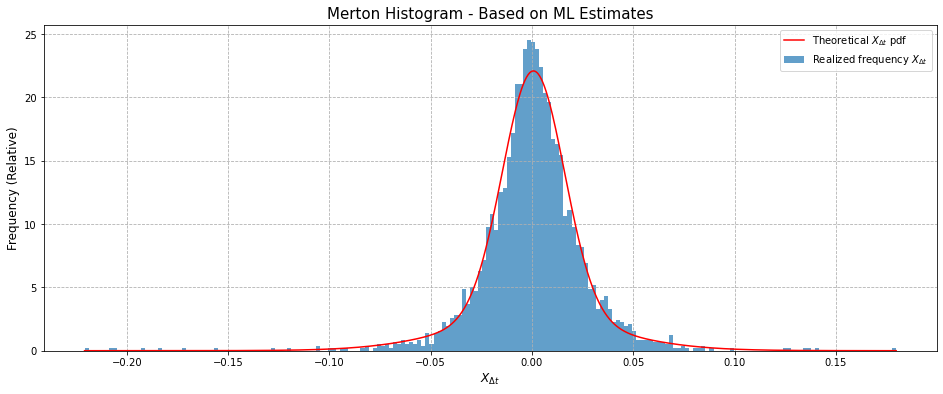

In [23]:
# parameters
gamma = MLE_df.loc['gamma', 'ML Estimate']     # drift 
sigma = MLE_df.loc['sigma', 'ML Estimate']     # diffusion coefficient
lam = MLE_df.loc['lambda', 'ML Estimate']      # intensity
alpha = MLE_df.loc['alpha', 'ML Estimate']     # jump size mean
beta = MLE_df.loc['beta', 'ML Estimate']       # jump size std dev
delta_t = 1 / 252                              # time delta b/w obs.

# plot histogram
x = np.linspace(stock_df['Daily Log Return'].min(), stock_df['Daily Log Return'].max(), 1000)
plt.figure(figsize = (16, 6))
plt.plot(x, merton_pdf(x, delta_t, gamma, sigma, lam, alpha, beta), color = 'r', label = 'Theoretical $X_{\Delta t}$ pdf')      # theoretical pdf
plt.hist(stock_df['Daily Log Return'], density = True, bins = 200, alpha = 0.7, label = 'Realized frequency $X_{\Delta t}$')    # observed frequencies
plt.title('Merton Histogram - Based on ML Estimates', size = 15)
plt.xlabel('$X_{\Delta t}$', size = 12)
plt.ylabel('Frequency (Relative)', size = 12)
plt.grid(True, linestyle = '--')
plt.legend();

---